In [33]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import os
from keras.layers import Layer
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import array_ops
from tensorflow.keras.layers import Input, Layer, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Dropout, GaussianNoise, Lambda, InputLayer
from tensorflow.keras.layers import concatenate, ZeroPadding2D, Cropping2D, Reshape, Flatten, SpatialDropout2D, Softmax, Embedding, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import gym
from keras.utils import plot_model
 #to fix error in the autoencoder.fit() , as in https://github.com/keras-team/keras/issues/16066
#https://dropsofai.com/variational-autoencoders-and-image-generation-with-keras/
#https://blog.paperspace.com/working-with-the-lambda-layer-in-keras/
#final fix for eager? https://linux-blog.anracom.com/2022/05/28/variational-autoencoder-with-tensorflow-2-8-iv-simple-rules-to-avoid-problems-with-eager-execution/
#https://linux-blog.anracom.com/2022/05/30/variational-autoencoder-with-tensorflow-2-8-v-a-customized-encoder-layer-for-the-kl-loss/



# First Version

In [32]:
atari_env_names = ['Assault','DemonAttack','SpaceInvaders','StarGunner']
next_game = str(np.random.choice(atari_env_names,1)[0])
env = gym.make(next_game+'-v0',full_action_space=True)
state = env.reset()

In [33]:
import cv2
episodes = 100
imgs = []
for i_episode in range(episodes):
    print("EPISODE",i_episode,"OF",episodes)
    next_game = str(np.random.choice(atari_env_names,1)[0])
    env = gym.make(next_game+'-v0',full_action_space=True)
    observation = env.reset()
    for t in range(10000):
        imgs.append(cv2.resize(env.env.ale.getScreenRGB(), (128,128)))
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break

EPISODE 0 OF 100
Episode finished after 757 timesteps
EPISODE 1 OF 100
Episode finished after 1832 timesteps
EPISODE 2 OF 100
Episode finished after 875 timesteps
EPISODE 3 OF 100


KeyboardInterrupt: 

In [ ]:
x_imgs = np.array(imgs)
x_imgs = x_imgs.astype('float32')
x_imgs /= 255
train = x_imgs[:len(imgs)*8//10]
val = x_imgs[len(imgs)*8//10:]

In [ ]:
train.shape

(83160, 128, 128, 3)

In [ ]:
PROJECT_ROOT_DIR = "/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/outputs/kerasimgs/"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def plot_image(image, save=False, i=0):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    if save:
      plt.savefig(str(i) + '.png')

def save_image(image, pred, i=0):
    ax1 = plt.subplot(1,2,1)
    ax2 = plt.subplot(1,2,2)
    ax1.imshow(image, cmap="binary")
    ax2.imshow(pred, cmap="binary")
#    plt.show()
#    plt.axis("off")
    plt.savefig(str(i) + '.png')

In [ ]:
latent_dim = 16

In [ ]:
class Sampling(tf.keras.layers.Layer):
    """
    Custom layer for the variational autoencoder
    It takes two vectors as input - one for means and other for variances of the latent variables described by a multimodal gaussian
    Its output is a latent vector randomly sampled from this distribution
    """
    def call(self, inputs):
        z_mean, z_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_var) * epsilon

In [ ]:

inputs = Input(shape=[128,128,3], name="Input")
x = inputs
x1 = Conv2D(8, 3, strides=1, padding='same', activation='selu', kernel_initializer='he_normal')(x)
x2 = Conv2D(8, 3, strides=1, padding='same', dilation_rate=(2,1), activation='selu', kernel_initializer='he_normal')(x)
x3 = Conv2D(8, 3, strides=1, padding='same', dilation_rate=(1,2), activation='selu', kernel_initializer='he_normal')(x)
x4 = Conv2D(8, 3, strides=1, padding='same', dilation_rate=(2,2), activation='selu', kernel_initializer='he_normal')(x)
x = concatenate([x1, x2, x3,x4])
x = BatchNormalization()(x)
x = Conv2D(32, 5, strides=2, padding='same', activation='selu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Conv2D(64, 5, strides=2, padding='same', activation='selu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Flatten()(x)
eo = Dense(256, activation='selu')(x)
enc = Model(inputs=inputs, outputs=eo)

z_mean = Dense(latent_dim)(eo)
z_var = Dense(latent_dim)(eo)
z = Sampling()([z_mean, z_var])

# Connecting the two encoder parts
enc = tf.keras.Model(inputs=inputs, outputs=z)

dec = Sequential([
    Dense(128*128*3, activation='relu'),
    Reshape((128,128,3)),
    Conv2DTranspose(128, 3, padding='same', activation='relu'),
    BatchNormalization(),
    Conv2DTranspose(3, 3, padding='same', activation='sigmoid')
])

'''
dec = Sequential([
                  Dense(256, activation='selu', input_shape=(16,), kernel_initializer='he_normal'),
                  Dropout(0.2),
                  Dense(512, activation='selu', kernel_initializer='he_normal'),
                  Dropout(0.2),
                  Dense(256, activation='selu', kernel_initializer='he_normal'),
                  Dropout(0.2),
                  Dense(84*84*3, activation='selu'),
                  Reshape((84,84,3)),
                  Conv2DTranspose(128, 3, padding='same', activation='selu'),
                  BatchNormalization(),
                  Conv2DTranspose(3, 3, padding='same', activation='sigmoid')
])'''

ae = Sequential([enc, dec])

In [ ]:
enc.compile(loss='mse')
enc.summary()

Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_60 (Conv2D)             (None, 128, 128, 8)  224         ['Input[0][0]']                  
                                                                                                  
 conv2d_61 (Conv2D)             (None, 128, 128, 8)  224         ['Input[0][0]']                  
                                                                                                  
 conv2d_62 (Conv2D)             (None, 128, 128, 8)  224         ['Input[0][0]']           

In [ ]:
dec.compile(loss='mse')
dec.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_68 (Dense)            (None, 49152)             835584    
                                                                 
 reshape_18 (Reshape)        (None, 128, 128, 3)       0         
                                                                 
 conv2d_transpose_44 (Conv2D  (None, 128, 128, 128)    3584      
 Transpose)                                                      
                                                                 
 batch_normalization_38 (Bat  (None, 128, 128, 128)    512       
 chNormalization)                                                
                                                                 
 conv2d_transpose_45 (Conv2D  (None, 128, 128, 3)      3459      
 Transpose)                                                      
                                                     

In [ ]:
ae.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_35 (Functional)       (None, 16)                16864000  
                                                                 
 sequential_16 (Sequential)  multiple                  843139    
                                                                 
Total params: 17,707,139
Trainable params: 17,706,627
Non-trainable params: 512
_________________________________________________________________


In [ ]:
ae.compile(loss='mse', optimizer=keras.optimizers.Adam(), metrics=['mean_absolute_error'])

In [ ]:
batch_size = 128
epochs = 200

In [ ]:
history = ae.fit(train, train, epochs=epochs, batch_size=batch_size, validation_data=(val, val), shuffle=True)

Epoch 1/200


2023-01-30 11:45:27.493809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


103/103 [==============================] - ETA: 0s - loss: 0.0690 - mean_absolute_error: 0.1962

2023-01-30 11:48:41.943160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


103/103 [==============================] - 216s 2s/step - loss: 0.0690 - mean_absolute_error: 0.1962 - val_loss: 0.0180 - val_mean_absolute_error: 0.0654
Epoch 2/200
103/103 [==============================] - 209s 2s/step - loss: 0.0146 - mean_absolute_error: 0.0602 - val_loss: 0.0181 - val_mean_absolute_error: 0.0626
Epoch 3/200
103/103 [==============================] - 207s 2s/step - loss: 0.0146 - mean_absolute_error: 0.0576 - val_loss: 0.0181 - val_mean_absolute_error: 0.0624
Epoch 4/200
103/103 [==============================] - 208s 2s/step - loss: 0.0146 - mean_absolute_error: 0.0568 - val_loss: 0.0181 - val_mean_absolute_error: 0.0622
Epoch 5/200
103/103 [==============================] - 208s 2s/step - loss: 0.0146 - mean_absolute_error: 0.0566 - val_loss: 0.0180 - val_mean_absolute_error: 0.0622
Epoch 6/200
103/103 [==============================] - 211s 2s/step - loss: 0.0146 - mean_absolute_error: 0.0563 - val_loss: 0.0180 - val_mean_absolute_error: 0.0627
Epoch 7/200
103/

KeyboardInterrupt: 

In [ ]:
pred = ae.predict(val)

2023-01-30 12:54:14.356493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


103/103 [==============================] - 23s 224ms/step


In [ ]:
pred.shape

(3279, 128, 128, 3)

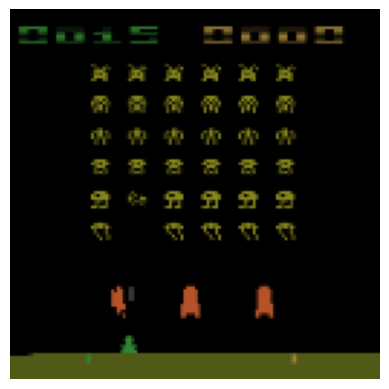

In [ ]:
plot_image(val[0], save=False, i=0)

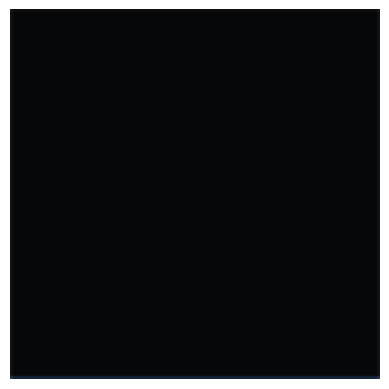

In [ ]:
plot_image(pred[0], save=False, i=0)

# Other Version

In [10]:
atari_env_names = ['Assault','DemonAttack','SpaceInvaders','StarGunner','BeamRider','Phoenix']
'''atari_env_names = ['Alien','Amidar','Assault','Asterix','Asteroids','Atlantis','DemonAttack','SpaceInvaders','StarGunner',\
                   'Berzerk','Bowling','Boxing','Breakout','Carnival','Centipede','Defender','Enduro',\
                   'Freeway','Frostbite','Gopher','Hero','Jamesbond','Kangaroo','Krull','Phoenix','Pitfall','Pong',\
                   'Pooyan','Qbert','Riverraid','Seaquest','Skiing','Solaris','Tennis','Tutankham','Venture','Zaxxon']'''

next_game = str(np.random.choice(atari_env_names,1)[0])
env = gym.make(next_game+'-v0',full_action_space=True)
state = env.reset()
import cv2
episodes = 20
imgs = []
for i_episode in range(episodes):
    print("EPISODE",i_episode,"OF",episodes)
    next_game = str(np.random.choice(atari_env_names,1)[0])
    env = gym.make(next_game+'-v0',full_action_space=True)
    observation = env.reset()
    for t in range(5000):
        obj = cv2.resize(env.env.ale.getScreenRGB(), (128,128))
        obj = tf.convert_to_tensor(obj,dtype=tf.float32)
        imgs.append(obj)
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
        
x_imgs = np.array(imgs)
x_imgs = x_imgs.astype('float32')
x_imgs /= 255
train = x_imgs[:len(imgs)*8//10]
val = x_imgs[len(imgs)*8//10:]
print(train.shape)
PROJECT_ROOT_DIR = "/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/outputs/kerasimgs/"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def plot_image(image, save=False, i=0):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    if save:
      plt.savefig(str(i) + '.png')

def save_image(image, pred, i=0):
    ax1 = plt.subplot(1,2,1)
    ax2 = plt.subplot(1,2,2)
    ax1.imshow(image, cmap="binary")
    ax2.imshow(pred, cmap="binary")
#    plt.show()
#    plt.axis("off")
    plt.savefig(str(i) + '.png')
    
latent_dim = 128

EPISODE 0 OF 20
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-13 16:43:25.225580: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-13 16:43:25.225685: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Episode finished after 823 timesteps
EPISODE 1 OF 20
Episode finished after 2486 timesteps
EPISODE 2 OF 20
Episode finished after 625 timesteps
EPISODE 3 OF 20
Episode finished after 1778 timesteps
EPISODE 4 OF 20
Episode finished after 417 timesteps
EPISODE 5 OF 20
Episode finished after 1989 timesteps
EPISODE 6 OF 20
Episode finished after 459 timesteps
EPISODE 7 OF 20
Episode finished after 582 timesteps
EPISODE 8 OF 20
Episode finished after 577 timesteps
EPISODE 9 OF 20
Episode finished after 1642 timesteps
EPISODE 10 OF 20
Episode finished after 737 timesteps
EPISODE 11 OF 20
Episode finished after 1879 timesteps
EPISODE 12 OF 20
Episode finished after 2517 timesteps
EPISODE 13 OF 20
Episode finished after 1461 timesteps
EPISODE 14 OF 20
Episode finished after 297 timesteps
EPISODE 15 OF 20
Episode finished after 674 timesteps
EPISODE 16 OF 20
Episode finished after 679 timesteps
EPISODE 17 OF 20
Episode finished after 791 timesteps
EPISODE 18 OF 20
Episode finished after 734 tim

In [3]:
from sys import getsizeof
getsizeof(train)

160

In [3]:
import tensorflow
 
input_data = tensorflow.keras.layers.Input(shape=(128,128, 3))
 
encoder = tensorflow.keras.layers.Conv2D(128, (5,5), activation='relu')(input_data)
#encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)
 
encoder = tensorflow.keras.layers.Conv2D(64, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)
 
encoder = tensorflow.keras.layers.Conv2D(32, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)

#encoder = tensorflow.keras.layers.Conv2D(16, (3,3), activation='relu')(encoder)
#encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)
 
encoder = tensorflow.keras.layers.Flatten()(encoder)
encoder = tensorflow.keras.layers.Dense(latent_dim)(encoder)

In [16]:
class Sampling(tf.keras.layers.Layer):
    """
    Custom layer for the variational autoencoder
    It takes two vectors as input - one for means and other for variances of the latent variables described by a multimodal gaussian
    Its output is a latent vector randomly sampled from this distribution
    """
    def call(self, inputs):
        z_mean, z_var = inputs
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_var) * epsilon

In [6]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tensorflow.shape(distribution_variance)[0]
    random = tensorflow.keras.backend.random_normal(shape=(batch_size, tensorflow.shape(distribution_variance)[1]))
    return distribution_mean + tensorflow.exp(0.5 * distribution_variance) * random
 
distribution_mean = tensorflow.keras.layers.Dense(latent_dim, name='mean')(encoder)
distribution_variance = tensorflow.keras.layers.Dense(latent_dim, name='log_variance')(encoder)
z = tensorflow.keras.layers.Lambda(sample_latent_features)([distribution_mean, distribution_variance])

In [17]:
distribution_mean = tensorflow.keras.layers.Dense(latent_dim, name='mean')(encoder)
distribution_variance = tensorflow.keras.layers.Dense(latent_dim, name='log_variance')(encoder)
z = Sampling()([distribution_mean, distribution_variance])

In [7]:
encoder_model = tensorflow.keras.Model(input_data, z)
encoder_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 124, 124, 12  9728        ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 122, 122, 64  73792       ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
#encoder_model.save('/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/models/encoder128.h5')
#encoder_model.load_weights('/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/models/encoder128_w.h5')

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-05 02:08:45.360842: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-05 02:08:45.361003: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-05 02:08:45.369992: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-02-05 02:08:45.371388: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-05 02:08:45.371867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-05 02:08:45.390176: I tensorflow/core/grappler/optimizers/custom_graph

In [8]:
decoder_input = tensorflow.keras.layers.Input(shape=(latent_dim))
decoder = tensorflow.keras.layers.Dense(128*128*3)(decoder_input)
decoder = tensorflow.keras.layers.Reshape((128,128, 3))(decoder)
decoder = tensorflow.keras.layers.Conv2DTranspose(32, 3, activation='relu',padding='same')(decoder)
decoder = tensorflow.keras.layers.Conv2DTranspose(64, 3, activation='relu',padding='same')(decoder)
decoder = tensorflow.keras.layers.Conv2DTranspose(128, 3, activation='relu',padding='same')(decoder)
decoder = tensorflow.keras.layers.BatchNormalization()(decoder) 
decoder_output = tensorflow.keras.layers.Conv2DTranspose(3, 3, activation='sigmoid',padding='same')(decoder)
#decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)
 
#decoder = tensorflow.keras.layers.Conv2DTranspose(64, (4,4), activation='relu')(decoder)
#decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)
 
#decoder_output = tensorflow.keras.layers.Conv2DTranspose(1, (5,5), activation='relu')(decoder)

decoder_model = tensorflow.keras.Model(decoder_input, decoder_output)
decoder_model.summary()

'''
dec = Sequential([
    Dense(128*128*3, activation='relu'),
    Reshape((128,128,3)),
    Conv2DTranspose(128, 3, padding='same', activation='relu'),
    BatchNormalization(),
    Conv2DTranspose(3, 3, padding='same', activation='sigmoid')
])


dec = Sequential([
                  Dense(256, activation='selu', input_shape=(16,), kernel_initializer='he_normal'),
                  Dropout(0.2),
                  Dense(512, activation='selu', kernel_initializer='he_normal'),
                  Dropout(0.2),
                  Dense(256, activation='selu', kernel_initializer='he_normal'),
                  Dropout(0.2),
                  Dense(84*84*3, activation='selu'),
                  Reshape((84,84,3)),
                  Conv2DTranspose(128, 3, padding='same', activation='selu'),
                  BatchNormalization(),
                  Conv2DTranspose(3, 3, padding='same', activation='sigmoid')
])'''

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_1 (Dense)             (None, 49152)             6340608   
                                                                 
 reshape (Reshape)           (None, 128, 128, 3)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 128, 128, 32)     896       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 128, 128, 64)     18496     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 128, 128, 128)    7385

"\ndec = Sequential([\n    Dense(128*128*3, activation='relu'),\n    Reshape((128,128,3)),\n    Conv2DTranspose(128, 3, padding='same', activation='relu'),\n    BatchNormalization(),\n    Conv2DTranspose(3, 3, padding='same', activation='sigmoid')\n])\n\n\ndec = Sequential([\n                  Dense(256, activation='selu', input_shape=(16,), kernel_initializer='he_normal'),\n                  Dropout(0.2),\n                  Dense(512, activation='selu', kernel_initializer='he_normal'),\n                  Dropout(0.2),\n                  Dense(256, activation='selu', kernel_initializer='he_normal'),\n                  Dropout(0.2),\n                  Dense(84*84*3, activation='selu'),\n                  Reshape((84,84,3)),\n                  Conv2DTranspose(128, 3, padding='same', activation='selu'),\n                  BatchNormalization(),\n                  Conv2DTranspose(3, 3, padding='same', activation='sigmoid')\n])"

In [ ]:
#decoder_model.load_weights('/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/models/decoder128_w.h5')
#decoder_model.save_weights('/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/models/decoder128_w.h5')

2023-02-05 02:08:45.707497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-05 02:08:45.722962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-05 02:08:45.809093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [9]:
encoded = encoder_model(input_data)
decoded = decoder_model(encoded)
autoencoder = tensorflow.keras.models.Model(input_data, decoded)
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 model (Functional)          (None, 128)               3579872   
                                                                 
 model_1 (Functional)        (None, 128, 128, 3)       6437827   
                                                                 
Total params: 10,017,699
Trainable params: 10,017,443
Non-trainable params: 256
_________________________________________________________________


In [ ]:
#autoencoder.save_weights('/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/models/vae128_w.h5')
#autoencoder.load_weights('/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/models/vae128_w.h5')

2023-02-05 02:08:51.382084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [10]:
def get_loss(distribution_mean, distribution_variance):
     
    def get_reconstruction_loss(y_true, y_pred):
        reconstruction_loss = tensorflow.keras.losses.mse(y_true, y_pred)
        reconstruction_loss_batch = tensorflow.reduce_mean(reconstruction_loss)
        return reconstruction_loss_batch*128*128*3
     
    def get_kl_loss(distribution_mean, distribution_variance):
        kl_loss = 1 + distribution_variance - tensorflow.square(distribution_mean) - tensorflow.exp(distribution_variance)
        kl_loss_batch = tensorflow.reduce_mean(kl_loss)
        return kl_loss_batch*(-0.5)
     
    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance)
        return reconstruction_loss_batch + kl_loss_batch
     
    return total_loss

In [11]:
autoencoder.compile(loss=get_loss(distribution_mean, distribution_variance), optimizer='adam')

In [23]:
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

In [12]:
autoencoder.fit(train, train, epochs=20, batch_size=128, validation_data=(val, val))

Epoch 1/20


2023-02-13 16:24:07.527042: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


TypeError: in user code:

    File "/Users/antoniomone/miniforge3/envs/wannenvjup/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/Users/antoniomone/miniforge3/envs/wannenvjup/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/antoniomone/miniforge3/envs/wannenvjup/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/Users/antoniomone/miniforge3/envs/wannenvjup/lib/python3.10/site-packages/keras/engine/training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/antoniomone/miniforge3/envs/wannenvjup/lib/python3.10/site-packages/keras/engine/training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "/Users/antoniomone/miniforge3/envs/wannenvjup/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 317, in __call__
        self._total_loss_mean.update_state(
    File "/Users/antoniomone/miniforge3/envs/wannenvjup/lib/python3.10/site-packages/keras/utils/metrics_utils.py", line 77, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "/Users/antoniomone/miniforge3/envs/wannenvjup/lib/python3.10/site-packages/keras/metrics/base_metric.py", line 143, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/Users/antoniomone/miniforge3/envs/wannenvjup/lib/python3.10/site-packages/keras/metrics/base_metric.py", line 486, in update_state  **
        sample_weight = tf.__internal__.ops.broadcast_weights(
    File "/Users/antoniomone/miniforge3/envs/wannenvjup/lib/python3.10/site-packages/keras/engine/keras_tensor.py", line 283, in __array__
        raise TypeError(

    TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'tf.cast_2'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.


In [ ]:
encoder_model.save_weights('/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/models/encoder128_w.h5')
decoder_model.save_weights('/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/models/decoder128_w.h5')
autoencoder.save_weights('/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/models/vae128_w.h5')

# Checks

In [16]:
pred = autoencoder.predict(val) #after 80 epochs

TypeError: 'MyVariationalAutoencoder' object is not callable

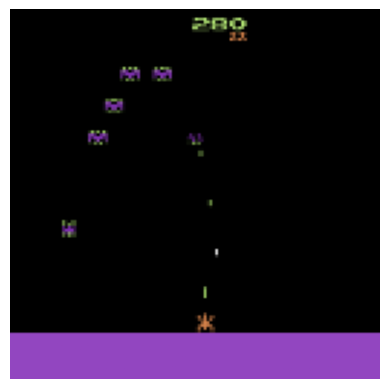

In [27]:
plot_image(val[3000], save=False, i=0)

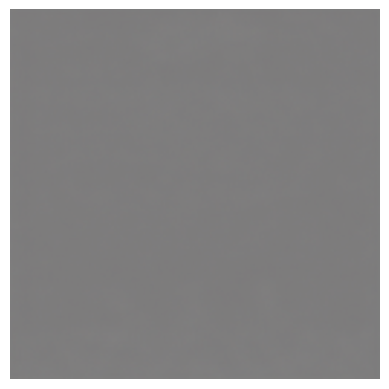

In [28]:
plot_image(pred[3000],save=False, i=0)

2023-02-13 16:21:16.916343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 16:21:17.023414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


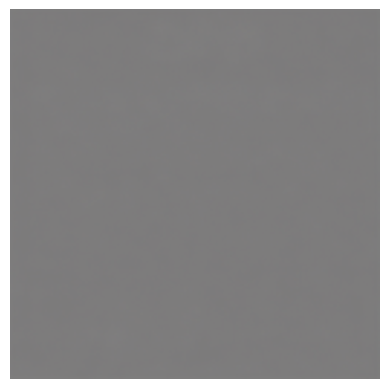

In [29]:
nextimage = np.reshape(val[3000],(1,128,128,3))
enc_image = encoder_model.predict(nextimage)
dec_image = decoder_model.predict(enc_image)
final_image = np.reshape(dec_image,(128,128,3))
plot_image(final_image,save=False)

Playing StarGunner
Game: 1 Score: 800.0 After 868 steps
Playing Assault
Game: 2 Score: 399.0 After 815 steps
Playing DemonAttack
Game: 3 Score: 190.0 After 1337 steps
Playing Phoenix
Game: 4 Score: 760.0 After 922 steps
Playing Phoenix
Game: 5 Score: 1730.0 After 1052 steps
Highest Score: 1730.0 Average of: 193.95 over 20 episodes


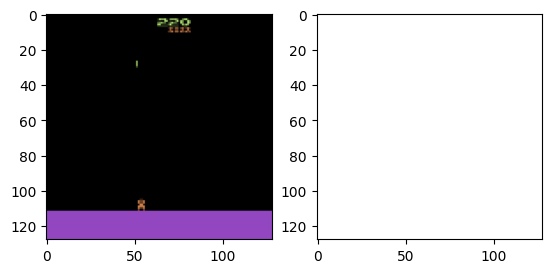

In [30]:
test_ep = 5

highest_score = 0
average = 0

for episode in range(test_ep):
    next_game = str(np.random.choice(atari_env_names,1)[0])
    env = gym.make(next_game+'-v0',full_action_space=True)
    print("Playing",next_game)
    state = env.reset()
    #print("Assault state",state.shape)
    done = False
    score = 0
    i=0
    while not done:
        action = env.action_space.sample()
        #print("ACTION:",action) #simply an int for Atari
        #print("Action type",type(action))
        n_state, reward, done, info = env.step(action)
        #print("obs shape",n_state.shape)
        if i==256:
            res = cv2.resize(env.env.ale.getScreenRGB(),(128,128))
            to_eval = np.reshape(res,(1,128,128,3))
            encoded_image = encoder_model.predict(to_eval)
            #print("ENCODED IMAGE",encoded_image)
            #print("ENCODED IMAGE SHAPE",encoded_image.shape)
            decoded_image = decoder_model.predict(encoded_image)
            to_comp = np.reshape(decoded_image,(128,128,3))
            to_eval = np.reshape(res,(128,128,3))
            save_image(to_eval,to_comp,i=i)
        score+=reward
        i+=1
    print("Game: {} Score: {} After {} steps".format(episode+1,score,i))
    if score > highest_score:
        highest_score=score
    average += score
    final_avg = average/episodes
    
print("Highest Score:",highest_score,"Average of:",final_avg,"over",episodes,"episodes")
env.close()


In [ ]:
plot_image(env.env.ale.getScreenRGB())

In [ ]:
new_enc = keras.models.load_model('/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/models/encoder128.h5')

2023-02-04 18:48:16.755282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-04 18:48:16.792836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-04 18:48:16.864492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


# WANDB (OPTIONAL)

In [ ]:
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
latent_dim = 128
epochs = 15
batch = 64

In [ ]:
print(tf.executing_eagerly())

True


In [ ]:
wandb.init(
    # set the wandb project where this run will be logged
    project="vae-improver",

    # track hyperparameters and run metadata with wandb.config
    config={
        "optimizer": "adam",
        "loss": "total_loss",
        "metric": "accuracy",
        "epoch": epochs,
        "batch_size": batch
    }
)

autoencoder.compile(loss=get_loss(distribution_mean, distribution_variance), optimizer='adam')

autoencoder.fit(train, train, epochs=epochs, batch_size=batch, validation_data=(val, val), callbacks=[ WandbMetricsLogger(log_freq=1),WandbModelCheckpoint("models")])

wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: antoniomone97. Use `wandb login --relogin` to force relogin


Epoch 1/15


2023-02-05 01:59:33.020476: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


TypeError: in user code:

    File "/Users/antoniomone/miniforge3/envs/wannenvjup/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/Users/antoniomone/miniforge3/envs/wannenvjup/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/antoniomone/miniforge3/envs/wannenvjup/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/Users/antoniomone/miniforge3/envs/wannenvjup/lib/python3.10/site-packages/keras/engine/training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/antoniomone/miniforge3/envs/wannenvjup/lib/python3.10/site-packages/keras/engine/training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "/Users/antoniomone/miniforge3/envs/wannenvjup/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 317, in __call__
        self._total_loss_mean.update_state(
    File "/Users/antoniomone/miniforge3/envs/wannenvjup/lib/python3.10/site-packages/keras/utils/metrics_utils.py", line 77, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "/Users/antoniomone/miniforge3/envs/wannenvjup/lib/python3.10/site-packages/keras/metrics/base_metric.py", line 143, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/Users/antoniomone/miniforge3/envs/wannenvjup/lib/python3.10/site-packages/keras/metrics/base_metric.py", line 486, in update_state  **
        sample_weight = tf.__internal__.ops.broadcast_weights(
    File "/Users/antoniomone/miniforge3/envs/wannenvjup/lib/python3.10/site-packages/keras/engine/keras_tensor.py", line 283, in __array__
        raise TypeError(

    TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'tf.cast_2'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.


# Extra Version

In [1]:
import sys
import numpy as np
import os
import gym
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, \
                                    Activation, BatchNormalization, ReLU, LeakyReLU, ELU, Dropout, AlphaDropout, Add
from tensorflow.keras.models import Model
# to be consistent with my standard loading of the Keras backend in Jupyter notebooks:  
from tensorflow.keras import backend as B      
from tensorflow.keras.optimizers import Adam
import numpy as np
import time 
import os
import sklearn # could be used for scalers
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpat 

# tensorflow and keras 
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.python.keras import backend as B 
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import schedules
from tensorflow.keras.utils import to_categorical
from tensorflow.python.client import device_lib
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# credits to https://linux-blog.anracom.com/2022/11/07/variational-autoencoder-with-tensorflow-2-8-xiii-does-a-vae-with-tiny-kl-loss-behave-like-an-ae-and-if-so-why/


# Grayscale dataset

In [2]:
finalgames = ['BattleZone','DoubleDunk','NameThisGame','Phoenix','Qbert']
single_atari = ['Phoenix']
#finalgames = ['Centipede','Robotank','Tennis','IceHockey','UpNDown','Carnival','Atlantis']
GAME = single_atari[0]

In [86]:
#RUN TO CREATE NPY GRAYSCALE DATASET - TRAIN AND VAL
import cv2
episodes = 75
screensize = 84
imgs = []
for i_episode in range(episodes):
    print("EPISODE",i_episode+1,"OF",episodes)
    next_game = GAME#str(np.random.choice(single_atari,1)[0])
    env = gym.make(next_game+'-v0',full_action_space=True)
    observation = env.reset()
    for t in range(5000):
        #obj = cv2.resize(env.env.ale.getScreenRGB(), (screensize,screensize))
        obj = cv2.resize(env.env.ale.getScreenGrayscale(),(screensize,screensize))
        obj = tf.convert_to_tensor(obj,dtype=tf.float32)
        imgs.append(obj)
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            #print("Episode finished after {} timesteps".format(t+1))
            break
        
x_imgs = np.array(imgs)
x_imgs = x_imgs.astype('float32')
x_imgs /= 255
train = x_imgs[:len(imgs)*8//10]
val = x_imgs[len(imgs)*8//10:]
train = np.reshape(train,(train.shape[0],train.shape[1],train.shape[2],1))
val = np.reshape(val,(val.shape[0],val.shape[1],val.shape[2],1))
print(train.shape)
print(val.shape)
PROJECT_ROOT_DIR = "/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/datasets84/"
GAME = single_atari[0]
TRAIN_NAME = GAME+"_train"
VAL_NAME = GAME+"_val"
SIZE = str(screensize)+'_'+str(screensize)
EXT = ".npy" 
np.save(PROJECT_ROOT_DIR+GAME+'/'+SIZE+'/'+TRAIN_NAME+EXT, train)
np.save(PROJECT_ROOT_DIR+GAME+'/'+SIZE+'/'+VAL_NAME+EXT, val)
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

EPISODE 1 OF 75
EPISODE 2 OF 75
EPISODE 3 OF 75
EPISODE 4 OF 75
EPISODE 5 OF 75
EPISODE 6 OF 75
EPISODE 7 OF 75
EPISODE 8 OF 75
EPISODE 9 OF 75
EPISODE 10 OF 75
EPISODE 11 OF 75
EPISODE 12 OF 75
EPISODE 13 OF 75
EPISODE 14 OF 75
EPISODE 15 OF 75
EPISODE 16 OF 75
EPISODE 17 OF 75
EPISODE 18 OF 75
EPISODE 19 OF 75
EPISODE 20 OF 75
EPISODE 21 OF 75
EPISODE 22 OF 75
EPISODE 23 OF 75
EPISODE 24 OF 75
EPISODE 25 OF 75
EPISODE 26 OF 75
EPISODE 27 OF 75
EPISODE 28 OF 75
EPISODE 29 OF 75
EPISODE 30 OF 75
EPISODE 31 OF 75
EPISODE 32 OF 75
EPISODE 33 OF 75
EPISODE 34 OF 75
EPISODE 35 OF 75
EPISODE 36 OF 75
EPISODE 37 OF 75
EPISODE 38 OF 75
EPISODE 39 OF 75
EPISODE 40 OF 75
EPISODE 41 OF 75
EPISODE 42 OF 75
EPISODE 43 OF 75
EPISODE 44 OF 75
EPISODE 45 OF 75
EPISODE 46 OF 75
EPISODE 47 OF 75
EPISODE 48 OF 75
EPISODE 49 OF 75
EPISODE 50 OF 75
EPISODE 51 OF 75
EPISODE 52 OF 75
EPISODE 53 OF 75
EPISODE 54 OF 75
EPISODE 55 OF 75
EPISODE 56 OF 75
EPISODE 57 OF 75
EPISODE 58 OF 75
EPISODE 59 OF 75
EPISOD

# Dataset Creation

In [4]:
#atari_env_names = ['Assault','DemonAttack','SpaceInvaders','StarGunner','BeamRider','Phoenix']
'''atari_env_names = ['Alien','Amidar','Assault','Asterix','Asteroids','Atlantis','DemonAttack','SpaceInvaders','StarGunner',\
                   'Berzerk','Bowling','Boxing','Breakout','Carnival','Centipede','Defender','Enduro',\
                   'Freeway','Frostbite','Gopher','Hero','Jamesbond','Kangaroo','Krull','Phoenix','Pitfall','Pong',\
                   'Pooyan','Qbert','Riverraid','Seaquest','Skiing','Solaris','Tennis','Tutankham','Venture','VideoPinball','Zaxxon']'''
#GAMES: Boxing Centipede Robotank Tennis Ice_Hockey Pong Breakout Up_N_Down Carnival Atlantis
#single_atari = ['Centipede']
#single_atari = ['Robotank']
#single_atari = ['Tennis']
#single_atari = ['IceHockey']
#single_atari = ['UpNDown']
#single_atari = ['Carnival']
finalgames = ['BattleZone','DoubleDunk','NameThisGame','Phoenix','Qbert']
single_atari = ['Qbert']
#finalgames = ['Centipede','Robotank','Tennis','IceHockey','UpNDown','Carnival','Atlantis']
GAME = single_atari[0]


In [8]:
#RUN TO CREATE NPY DATASET - TRAIN AND VAL
import cv2
episodes = 75
screensize = 160
imgs = []
for i_episode in range(episodes):
    print("EPISODE",i_episode+1,"OF",episodes)
    next_game = str(single_atari[0])
    env = gym.make(next_game+'-v0',obs_type='image',full_action_space=True)
    observation = env.reset()
    for t in range(5000):
        obj = cv2.resize(env.env.ale.getScreenRGB(), (screensize,screensize))
        obj = tf.convert_to_tensor(obj,dtype=tf.float32)
        imgs.append(obj)
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            #print("Episode finished after {} timesteps".format(t+1))
            break
        
x_imgs = np.array(imgs)
x_imgs = x_imgs.astype('float32')
x_imgs /= 255
train = x_imgs[:len(imgs)*8//10]
val = x_imgs[len(imgs)*8//10:]
print(train.shape)
PROJECT_ROOT_DIR = "/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/datasets84/"
GAME = single_atari[0]
TRAIN_NAME = GAME+"_train"
VAL_NAME = GAME+"_val"
SIZE = str(screensize)+'_'+str(screensize)
EXT = ".npy" 
np.save(PROJECT_ROOT_DIR+GAME+'/'+SIZE+'/'+TRAIN_NAME+EXT, train)
np.save(PROJECT_ROOT_DIR+GAME+'/'+SIZE+'/'+VAL_NAME+EXT, val)
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

EPISODE 1 OF 75
EPISODE 2 OF 75
EPISODE 3 OF 75
EPISODE 4 OF 75
EPISODE 5 OF 75
EPISODE 6 OF 75
EPISODE 7 OF 75
EPISODE 8 OF 75
EPISODE 9 OF 75
EPISODE 10 OF 75
EPISODE 11 OF 75
EPISODE 12 OF 75
EPISODE 13 OF 75
EPISODE 14 OF 75
EPISODE 15 OF 75
EPISODE 16 OF 75
EPISODE 17 OF 75
EPISODE 18 OF 75
EPISODE 19 OF 75
EPISODE 20 OF 75
EPISODE 21 OF 75
EPISODE 22 OF 75
EPISODE 23 OF 75
EPISODE 24 OF 75
EPISODE 25 OF 75
EPISODE 26 OF 75
EPISODE 27 OF 75
EPISODE 28 OF 75
EPISODE 29 OF 75
EPISODE 30 OF 75
EPISODE 31 OF 75
EPISODE 32 OF 75
EPISODE 33 OF 75
EPISODE 34 OF 75
EPISODE 35 OF 75
EPISODE 36 OF 75
EPISODE 37 OF 75
EPISODE 38 OF 75
EPISODE 39 OF 75
EPISODE 40 OF 75
EPISODE 41 OF 75
EPISODE 42 OF 75
EPISODE 43 OF 75
EPISODE 44 OF 75
EPISODE 45 OF 75
EPISODE 46 OF 75
EPISODE 47 OF 75
EPISODE 48 OF 75
EPISODE 49 OF 75
EPISODE 50 OF 75
EPISODE 51 OF 75
EPISODE 52 OF 75
EPISODE 53 OF 75
EPISODE 54 OF 75
EPISODE 55 OF 75
EPISODE 56 OF 75
EPISODE 57 OF 75
EPISODE 58 OF 75
EPISODE 59 OF 75
EPISOD

In [304]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def plot_image(image, save=False, i=0):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    if save:
      plt.savefig(str(i) + '.png')

def save_image(image, pred, i=0):
    ax1 = plt.subplot(1,2,1)
    ax2 = plt.subplot(1,2,2)
    ax1.imshow(image, cmap="binary")
    ax2.imshow(pred, cmap="binary")
#    plt.show()
#    plt.axis("off")
    plt.savefig(str(i) + '.png')

In [398]:
# RUN TO LOAD NPY DATASET TO TRAIN AND VAL
screensize = 84
PROJECT_ROOT_DIR = "/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/datasets84/"
GAME = single_atari[0]
TRAIN_NAME = GAME+"_train"
VAL_NAME = GAME+"_val"
SIZE = str(screensize)+'_'+str(screensize)
EXT = ".npy" 
TRAIN_PATH = PROJECT_ROOT_DIR+GAME+'/'+SIZE+'/'+TRAIN_NAME+EXT
VAL_PATH = PROJECT_ROOT_DIR+GAME+'/'+SIZE+'/'+VAL_NAME+EXT
train = np.load(TRAIN_PATH)
val = np.load(VAL_PATH)
print(train.shape)
print(val.shape)

(39699, 84, 84, 1)
(9925, 84, 84, 1)


## Parameters

In [3]:
#MAIN PARAMETERS
screensize = 160
z_dim = 128
INITIAL_EPOCH = 0 
n_epochs      = 250
SOLUTION_TYPE = 3
solution_type = SOLUTION_TYPE
#INPUT_DIM = (screensize,screensize,1) #if grayscale
INPUT_DIM = (screensize,screensize,3) # if rgb
loss_type = 0 #0=BCE - 1=MSE , sigmoid with 0 and linear with 1
act = 1 #0 LeakyReLu, 1 ReLU, 2= SeLU
fact = 0
use_batch_norm  = True
use_dropout     = False
dropout_rate    = 0.1
n_ch  = INPUT_DIM[2]   # number of channels
if loss_type == 0:
    fact = 5.0
else:
    fact = 2.0e-2

In [4]:
# A child class of Model() to control train_step with GradientTape() 
class VAE(keras.Model): 
    
    # We use our self defined __init__() to provide a reference MyVAE 
    # to an object of type "MyVariationalAutoencoder" 
    # This in turn allows us to address the Encoder and the Decoder  
    def __init__(self, MyVAE, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.MyVAE   = MyVAE 
        self.encoder = self.MyVAE.encoder
        self.decoder = self.MyVAE.decoder
        
        # A factor to control the ratio between the KL loss and the reconstruction loss 
        self.fact = MyVAE.fact
        
        # A counter 
        self.count = 0 
        
        # A factor to scale the absolute values of the losses 
        # e.g. by the number of pixels of an image
        self.scale_fact = 1.0  # no scaling
        # self.scale_fact = tf.constant(self.MyVAE.input_dim[0] * self.MyVAE.input_dim[1], dtype=tf.float32)
        self.f_scale    = 1. / self.scale_fact
        
        # loss type : 0: BCE, 1: MSE 
        self.loss_type = self.MyVAE.loss_type
        
        # track loss development via metrics 
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reco_loss_tracker  = keras.metrics.Mean(name="reco_loss")
        self.kl_loss_tracker    = keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        x, z_m, z_var = self.encoder(inputs)
        return self.decoder(x)  

    # Overwrite the metrics() of Model() - use getter mechanism  
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reco_loss_tracker,
            self.kl_loss_tracker
        ]

    # Core function to control all operations regarding eager differentiation operations, 
    # i.e. the calculation of loss terms with respect to tensors and differentiation variables 
    # and metrics data 
    def train_step(self, data):
        # We use the GradientTape context to record differntiation operations/results 
        #self.count += 1 
        
        with tf.GradientTape() as tape:
            z, z_mean, z_log_var = self.encoder(data)
            reconstruction = self.decoder(z)
            #reco_shape = tf.shape(self.reconstruction)
            #print("reco_shape = ", reco_shape, self.reconstruction.shape, data.shape)
            
            #BCE loss (Binary Cross Entropy) 
            if self.loss_type == 0: 
                reconstruction_loss = tf.reduce_mean(
                    tf.reduce_sum(
                        keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                    )
                ) * self.f_scale
            
            # MSE loss (Mean Squared Error) 
            if self.loss_type == 1: 
                reconstruction_loss = tf.reduce_mean(
                    tf.reduce_sum(
                        keras.losses.mse(data, reconstruction), axis=(1, 2)
                    )
                ) * self.f_scale
            
            kl_loss = -0.5 * self.fact * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))  
            total_loss = reconstruction_loss + kl_loss 
        
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        #if self.count == 1: 
            
        self.total_loss_tracker.update_state(total_loss)
        self.reco_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reco_loss": self.reco_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
        
    def compile_VAE(self, learning_rate):

        # Optimizer
        # ~~~~~~~~~ 
        optimizer = Adam(learning_rate=learning_rate)
        # save the learning rate for possible intermediate output to files 
        self.learning_rate = learning_rate
        self.compile(optimizer=optimizer)

In [5]:
class My_KL_Layer(Layer):
    '''
    @note: Returns the input layers ! Required to allow for z-point calculation
           in a final Lambda layer of the Encoder model    
    '''
    # Standard initialization of layers 
    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(My_KL_Layer, self).__init__(*args, **kwargs)

    # The implementation interface of the Layer
    def call(self, inputs, fact = 4.5e-4):
        mu      = inputs[0]
        log_var = inputs[1]
        # Note: from other analysis we know that the backend applies tf.math.functions 
        # "fact" must be adjusted - for MNIST reasonable values are in the range of 0.65e-4 to 6.5e-4
        kl_mean_batch = - fact * B.mean(1 + log_var - B.square(mu) - B.exp(log_var))
        # We add the loss via the layer's add_loss() - it will be added up to other losses of the model     
        self.add_loss(kl_mean_batch, inputs=inputs)
        # We add the loss information to the metrics displayed during training 
        self.add_metric(kl_mean_batch, name='kl', aggregation='mean')
        return inputs

In [6]:
'''class CustomRes(Layer):
    def __init__(self,*args, **kwargs):
        super().__init__(*args,**kwargs)
    def call(self,x):
        y = Input(shape=(None,160,160,3))(x)
        y = Conv2D(kernel_size=3, strides=2, filters=64, padding='same')(y)
        y = BatchNormalization()(y)
        y = ReLU()(y)
        y = Conv2D(kernel_size=3, strides=2, filters=64, padding='same')(y)
        y = BatchNormalization()(y)
        y = ReLU()(y)
        out = Add()([x,y])
        return out
    
class CustomResT(Layer):
    def __init__(self,*args, **kwargs):
        super().__init__(*args,**kwargs)
    
    def call(self,x):
        y = Conv2DTranspose(kernel_size=3, strides=2, filters=64, padding='same')(x)
        y = BatchNormalization()(y)
        y = ReLU()(y)
        y = Conv2DTranspose(kernel_size=3, strides=2, filters=64, padding='same')(y)
        out = Add()([x,y])
        out = BatchNormalization()(out)
        out = ReLU()(out)
        return out'''
        

"class CustomRes(Layer):\n    def __init__(self,*args, **kwargs):\n        super().__init__(*args,**kwargs)\n    def call(self,x):\n        y = Input(shape=(None,160,160,3))(x)\n        y = Conv2D(kernel_size=3, strides=2, filters=64, padding='same')(y)\n        y = BatchNormalization()(y)\n        y = ReLU()(y)\n        y = Conv2D(kernel_size=3, strides=2, filters=64, padding='same')(y)\n        y = BatchNormalization()(y)\n        y = ReLU()(y)\n        out = Add()([x,y])\n        return out\n    \nclass CustomResT(Layer):\n    def __init__(self,*args, **kwargs):\n        super().__init__(*args,**kwargs)\n    \n    def call(self,x):\n        y = Conv2DTranspose(kernel_size=3, strides=2, filters=64, padding='same')(x)\n        y = BatchNormalization()(y)\n        y = ReLU()(y)\n        y = Conv2DTranspose(kernel_size=3, strides=2, filters=64, padding='same')(y)\n        out = Add()([x,y])\n        out = BatchNormalization()(out)\n        out = ReLU()(out)\n        return out"

In [20]:
def identity_block(x,filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filters=filter, kernel_size=3,strides=1, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filters=filter, kernel_size=3,strides=1, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    #x_skip = tf.keras.layers.Conv2D(filter, 1, strides = 1)(x_skip)
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def identity_block_transpose(x,filter):
        # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = Conv2DTranspose(kernel_size=3, strides=1, filters=filter, padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = Conv2DTranspose(kernel_size=3, strides=1, filters=filter, padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Add Residue
    #x_skip = tf.keras.layers.Conv2DTranspose(filter, 1, strides = 1)(x_skip)
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

#credits to https://www.analyticsvidhya.com/blog/2021/08/how-to-code-your-resnet-from-scratch-in-tensorflow/

In [21]:
class CustomLambda(Layer):
    def __init__(self, *args, **kwargs):
        super(CustomLambda,self).__init__(*args,**kwargs)
        
    def call(self,args):
            '''
            A point in the latent space is calculated statistically 
            around an optimized mu for each sample 
            '''
            mu, log_var = args # Note: These are 1D tensors !
            epsilon = B.random_normal(shape=B.shape(mu), mean=0., stddev=1.)
            return mu + B.exp(log_var / 2) * epsilon

In [22]:
# The Main class 
# ~~~~~~~~~~~~~~
class MyVariationalAutoencoder():
    '''
    Coding suggestions of D. Foster and F. Chollet were modified and extended by RMO 
    @version: V0.1, 25.04 
    @change:  added b_build_all 
    @version: V0.2, 08.05 
    @change:  Handling of the KL-loss via functions (partially not working)  
    @version: V0.3, 29.05 
    @change:  Handling of the KL-loss function via a customized Encoder layer 
    '''
    
    def __init__(self
        , input_dim                  # the shape of the input tensors (for MNIST (28,28,1)) 
        , encoder_conv_filters       # number of maps of the different Conv2D layers   
        , encoder_conv_kernel_size   # kernel sizes of the Conv2D layers 
        , encoder_conv_strides       # strides - here also used to reduce spatial resolution avoid pooling layers 
                                     # used instead of Pooling layers 
        , encoder_conv_padding       # padding - valid or same  
        
        , decoder_conv_t_filters     # number of maps in Con2DTranspose layers 
        , decoder_conv_t_kernel_size # kernel sizes of Conv2D Transpose layers  
        , decoder_conv_t_strides     # strides for Conv2dTranspose layers - inverts spatial resolution
        , decoder_conv_t_padding     # padding - valid or same  
        
        , z_dim                      # A good start is 16 or 24  
        , solution_type  = 0         # Which type of solution for the KL loss calculation ?
        , act            = 0         # Which type of activation function?  
        , fact           = 0.65e-4   # Factor for the KL loss (0.5e-4 < fact < 1.e-3is reasonable) 
        , loss_type      = 0         # 0: BCE, 1: MSE   
        , use_batch_norm = False     # Shall BatchNormalization be used after Conv2D layers? 
        , use_dropout    = False     # Shall statistical dropout layers be used for tregularization purposes ? 
        , dropout_rate   = 0.25      # Rate for statistical dropout layer  
        , b_build_all    = False     # Added by RMO - full Model is build in 2 steps 
        ):
        
        '''
        Input: 
        The encoder_... and decoder_.... variables are Python lists,
        whose length defines the number of Conv2D and Conv2DTranspose layers 
        
        input_dim : Shape/dimensions of the input tensor - for MNIST (28,28,1) 
        encoder_conv_filters:     List with the number of maps/filters per Conv2D layer    
        encoder_conv_kernel_size: List with the kernel sizes for the Conv-Layers   
        encoder_conv_strides:     List with the strides used for the Conv-Layers   

        z_dim : dimension of the "latent_space"
        solution_type : Type of solution for KL loss calculation (0: Customized Encoder layer, 
                                                                  1: transfer of mu, var_log to Decoder 
                                                                  2: model.add_loss()
                                                                  3: definition of training step with Gradient.Tape()
        
        act :  determines activation function to use (0: LeakyRELU, 1:RELU , 2: SELU)
               !!!! NOTE: !!!!
               If SELU is used then the weight kernel initialization and the dropout layer need to be special   
               https://github.com/christianversloot/machine-learning-articles/blob/main/using-selu-with-tensorflow-and-keras.md
               AlphaDropout instead of Dropout + LeCunNormal for kernel initializer
        fact = 0.65e-4 : Factor to scale the KL loss relative to the reconstruction loss
                         Must be adapted to the way of calculation - 
                         e.g. for solution_type == 3 the loss is not averaged over all pixels 
                         => at least factor of around 1000 bigger than normally 
        loss-type = 0:   Defines the way we calculate a reconstruction loss 
                         0: Binary Cross Entropy - recommended by many authors 
                         1: Mean Square error - recommended by some authors especially for "face arithmetics"
        use_batch_norm = False   # True : We use BatchNormalization   
        use_dropout    = False   # True : We use dropout layers (rate = 0.25, see Encoder)
        b_build_all    = False   # True : Full VAE Model is build in 1 step; 
                                   False: Encoder, Decoder, VAE are build in separate steps   
        '''
        
        self.name = 'variational_autoencoder'

        # Parameters for Layers which define the Encoder and Decoder 
        self.input_dim                  = input_dim
        self.encoder_conv_filters       = encoder_conv_filters
        self.encoder_conv_kernel_size   = encoder_conv_kernel_size
        self.encoder_conv_strides       = encoder_conv_strides
        self.encoder_conv_padding       = encoder_conv_padding
        
        self.decoder_conv_t_filters     = decoder_conv_t_filters
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        self.decoder_conv_t_strides     = decoder_conv_t_strides
        self.decoder_conv_t_padding     = decoder_conv_t_padding
        
        self.z_dim = z_dim

        # Check param for activation function 
        if act < 0 or act > 2: 
            print("Range error: Parameter act = " + str(act) + " has unknown value ")  
            sys.exit()
        else:
            self.act = act 
        
        # Factor to scale the KL loss relative to the Binary Cross Entropy loss 
        self.fact = fact 
        
        # Type of loss - 0: BCE, 1: MSE 
        self.loss_type = loss_type
        
        
        # Check param for solution approach  
        if solution_type < 0 or solution_type > 3: 
            print("Range error: Parameter solution_type = " + str(solution_type) + " has unknown value ")  
            sys.exit()
        else:
            self.solution_type = solution_type 

        self.use_batch_norm = use_batch_norm
        self.use_dropout    = use_dropout
        self.dropout_rate   = dropout_rate

        # Preparation of some variables to be filled later 
        self._encoder_input  = None  # receives the Keras object for the Input Layer of the Encoder 
        self._encoder_output = None  # receives the Keras object for the Output Layer of the Encoder 
        self.shape_before_flattening = None # info of the Encoder => is used by Decoder 
        self._decoder_input  = None  # receives the Keras object for the Input Layer of the Decoder
        self._decoder_output = None  # receives the Keras object for the Output Layer of the Decoder

        # Layers / tensors for KL loss 
        self.mu      = None # receives special Dense Layer's tensor for KL-loss 
        self.log_var = None # receives special Dense Layer's tensor for KL-loss 

        # Parameters for SELU - just in case we may need to use it somewhere 
        # https://keras.io/api/layers/activations/ see selu
        self.selu_scale = 1.05070098
        self.selu_alpha = 1.67326324

        # The number of Conv2D and Conv2DTranspose layers for the Encoder / Decoder 
        self.n_layers_encoder = len(encoder_conv_filters)
        self.n_layers_decoder = len(decoder_conv_t_filters)

        self.num_epoch = 0 # Intialization of the number of epochs 

        # A matrix for the values of the losses 
        self.std_loss  = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)

        # We only build the whole AE-model if requested
        self.b_build_all = b_build_all
        if b_build_all:
            self._build_all()


    def _build_enc(self, solution_type = -1, fact=-1.0):
        '''  Your documentation '''
        # Checking whether "fact" and "solution_type" for the KL loss shall be overwritten
        if fact < 0:
            fact = self.fact  
        if solution_type < 0:
            solution_type = self.solution_type
        else: 
            self.solution_type = solution_type
        
        # Preparation: We later need a function to calculate the z-points in the latent space 
        # The following function wiChangedll be used by an eventual Lambda layer of the Encoder 
        '''def z_point_sampling(args):
            
            A point in the latent space is calculated statistically 
            around an optimized mu for each sample 
            
            mu, log_var = args # Note: These are 1D tensors !
            epsilon = B.random_normal(shape=B.shape(mu), mean=0., stddev=1.)
            return mu + B.exp(log_var / 2) * epsilon'''

        
        # Input "layer"
        self._encoder_input = Input(shape=self.input_dim, name='encoder_input')

        # Initialization of a running variable x for individual layers 
        x = self._encoder_input
        # Build the CNN-part with Conv2D layers 
        # Note that stride>=2 reduces spatial resolution without the help of pooling layers 
        for i in range(self.n_layers_encoder):
            conv_layer = Conv2D(
                filters = self.encoder_conv_filters[i]
                , kernel_size = self.encoder_conv_kernel_size[i]
                , strides = self.encoder_conv_strides[i]
                , padding = self.encoder_conv_padding[i]  # Important ! Controls the shape of the layer tensors.    
                , name = 'encoder_conv_' + str(i)
                )
            x = conv_layer(x)
            
            # The "normalization" should be done ahead of the "activation" 
            if self.use_batch_norm:
                x = BatchNormalization()(x)

            # Selection of activation function (out of 3)      
            if self.act == 0:
                x = LeakyReLU()(x)
            elif self.act == 1:
                x = ReLU()(x)
            elif self.act == 2: 
                # RMO: Just use the Activation layer to use SELU with predefined (!) parameters 
                x = Activation('selu')(x) 

            # Fulfill some SELU requirements 
            if self.use_dropout:
                if self.act == 2: 
                    x = AlphaDropout(rate = 0.25)(x)
                else:
                    x = Dropout(rate = 0.25)(x)
        x = identity_block(x,filter=self.encoder_conv_filters[self.n_layers_encoder-1])
        # Last multi-dim tensor shape - is later needed by the decoder 
        self._shape_before_flattening = B.int_shape(x)[1:]

        # Flattened layer before calculating VAE-output (z-points) via 2 special layers 
        x = Flatten()(x)
        
        # "Variational" part - create 2 Dense layers for a statistical distribution of z-points  
        self.mu      = Dense(self.z_dim, name='mu')(x)
        self.log_var = Dense(self.z_dim, name='log_var')(x)

        if solution_type == 0: 
            # Customized layer for the calculation of the KL loss based on mu, var_log data
            # We use a customized layer according to a class definition  
            self.mu, self.log_var = My_KL_Layer()([self.mu, self.log_var], fact=fact)


        # Layer to provide a z_point in the Latent Space for each sample of the batch 
        #self._encoder_output = Lambda(z_point_sampling, name='encoder_output')([self.mu, self.log_var])
        self._encoder_output = CustomLambda()([self.mu, self.log_var])
        # The Encoder Model 
        # ~~~~~~~~~~~~~~~~~~~
        # With extra KL layer or with vae.add_loss()
        if self.solution_type == 0 or self.solution_type == 2: 
            self.encoder = Model(self._encoder_input, self._encoder_output, name="encoder")
        
        # Transfer solution => Multiple outputs 
        if self.solution_type == 1  or self.solution_type == 3: 
            self.encoder = Model(inputs=self._encoder_input, outputs=[self._encoder_output, self.mu, self.log_var], name="encoder")
            
    def _build_dec(self):
        ''' Your documentation       '''       
 
        # Input layer - aligned to the shape of z-points in the latent space = output[0] of the Encoder 
        self._decoder_inp_z = Input(shape=(self.z_dim,), name='decoder_input')
        
        # Additional Input layers for the KL tensors (mu, log_var) from the Encoder
        if self.solution_type == 1  or self.solution_type == 3: 
            self._dec_inp_mu       = Input(shape=(self.z_dim), name='mu_input')
            self._dec_inp_var_log  = Input(shape=(self.z_dim), name='logvar_input')
            
            # We give the layers later used as output a name 
            # Each of the Activation layers below just correspond to an identity passed through 
            #self._dec_mu            = self._dec_inp_mu 
            #self._dec_var_log       = self._dec_inp_var_log 
            self._dec_mu            = Activation('linear',name='dc_mu')(self._dec_inp_mu) 
            self._dec_var_log       = Activation('linear', name='dc_var')(self._dec_inp_var_log) 

        # Here we use the tensor shape info from the Encoder          
        x = Dense(np.prod(self._shape_before_flattening))(self._decoder_inp_z)
        x = Reshape(self._shape_before_flattening)(x)
        x = identity_block_transpose(x,filter=self.decoder_conv_t_filters[0])
        # The inverse CNN
        for i in range(self.n_layers_decoder):
            conv_t_layer = Conv2DTranspose(
                filters = self.decoder_conv_t_filters[i]
                , kernel_size = self.decoder_conv_t_kernel_size[i]
                , strides = self.decoder_conv_t_strides[i]
                , padding = self.decoder_conv_t_padding[i] # Important ! Controls the shape of tensors during reconstruction
                                   # we want an image with the same resolution as the original input 
                , name = 'decoder_conv_t_' + str(i)
                )
            x = conv_t_layer(x)

            # Normalization and Activation 
            if i < self.n_layers_decoder - 1:
                # Also in the decoder: normalization before activation  
                if self.use_batch_norm:
                    x = BatchNormalization()(x)
                
                # Choice of activation function
                if self.act == 0:
                    x = LeakyReLU()(x)
                elif self.act == 1:
                    x = ReLU()(x)
                elif self.act == 2: 
                    #x = self.selu_scale * ELU(alpha=self.selu_alpha)(x)
                    x = Activation('selu')(x)
                
                # Adaptions to SELU requirements 
                if self.use_dropout:
                    if self.act == 2: 
                        x = AlphaDropout(rate = 0.25)(x)
                    else:
                        x = Dropout(rate = 0.25)(x)
                
            # Last layer => Sigmoid output 
            # => This requires s<pre style="padding:8px; height: 400px; overflow:auto;">caled input => Division of pixel values by 255
            else:
                x = Activation('sigmoid', name='dc_reco')(x)

        # Output tensor => a scaled image 
        self._decoder_output = x

        # The Decoder model 
        # solution_type == 0/2/3: Just the decoded input 
        if self.solution_type == 0 or self.solution_type == 2 or self.solution_type == 3: 
            self.decoder = Model(self._decoder_inp_z, self._decoder_output, name="decoder")
        
        # solution_type == 1: The decoded tensor plus the transferred tensors mu and log_var a for the variational distribution 
        if self.solution_type == 1: 
            self.decoder = Model([self._decoder_inp_z, self._dec_inp_mu, self._dec_inp_var_log], 
                                 [self._decoder_output, self._dec_mu, self._dec_var_log], name="decoder")
    # Function to build the full VAE
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
    def _build_VAE(self):     
        ''' Your documentation '''
        
        # Solution with train_step() and GradientTape(): Control is transferred to class VAE  
        if self.solution_type == 3:
            self.model = VAE(self)   # Here parameter "self" provides a reference to an instance of MyVariationalAutoencoder
            #self.model.summary()
        
        # Solutions with layer.add_loss or model.add_loss() 
        if self.solution_type == 0 or self.solution_type == 2:
            model_input  = self._encoder_input
            model_output = self.decoder(self._encoder_output)
            self.model = Model(model_input, model_output, name="vae")

        # Solution with transfer of data from the Encoder to the Decoder output layer
        if self.solution_type == 1: 
            enc_out      = self.encoder(self._encoder_input)
            dc_reco, dc_mu, dc_var = self.decoder(enc_out)
            # We organize the output and later association of cost functions and metrics via a dictionary 
            mod_outputs = {'vae_out_main': dc_reco, 'vae_out_mu': dc_mu, 'vae_out_var': dc_var}
            self.model = Model(inputs=self._encoder_input, outputs=mod_outputs, name="vae")

    # Function to build full AE in one step if requested
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    def _build_all(self):
        self._build_enc()
        self._build_dec()
        self._build_VAE()
    # Function to compile VA-model with a KL-layer in the Encoder 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    def compile_for_KL_Layer(self, learning_rate):
        if self.solution_type != 0: 
            print("The compile_L() function is only compatible with solution_type = 0")
            sys.exit()
        self.learning_rate = learning_rate
        # Optimizer 
        optimizer = Adam(learning_rate=learning_rate)
        self.model.compile(optimizer=optimizer, loss="binary_crossentropy",
                           metrics=[tf.keras.metrics.BinaryCrossentropy(name='bce')])
    def train_model_with_KL_Layer(self, x_train, batch_size, epochs, initial_epoch = 0):
        self.model.fit(     
            x_train
            , x_train
            , batch_size = batch_size
            , shuffle = True
            , epochs = epochs
            , initial_epoch = initial_epoch
        )

    # Function to compile the full VAE
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
    def compile_myVAE(self, learning_rate):
    
        # Optimizer
        # ~~~~~~~~~ 
        optimizer = Adam(learning_rate=learning_rate)
        # save the learning rate for possible intermediate output to files 
        self.learning_rate = learning_rate
        
        # Parameter "fact" will be used by the cost functions defined below to scale the KL loss relative to the BCE loss 
        fact = self.fact
        
        # Function for solution_type == 1
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  
        @tf.function
        def mu_loss(y_true, y_pred):
            loss_mux = fact * tf.reduce_mean(tf.square(y_pred))
            return loss_mux
        
        @tf.function
        def logvar_loss(y_true, y_pred):
            loss_varx = -fact * tf.reduce_mean(1 + y_pred - tf.exp(y_pred))    
            return loss_varx

        # Function for solution_type == 2 
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # We follow an approach described at  
        # https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer
        # NOTE: We can NOT use @tf.function here 
        def get_kl_loss(mu, log_var):
            kl_loss = -fact * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
            return kl_loss


        # Required operations for solution_type==2 => model.add_loss()
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        res_kl = get_kl_loss(mu=self.mu, log_var=self.log_var)

        if self.solution_type == 2: 
            self.model.add_loss(res_kl)    
            self.model.add_metric(res_kl, name='kl', aggregation='mean')
        
        # Model compilation 
        # ~~~~~~~~~~~~~~~~~~~~
        
        # Solutions with layer.add_loss or model.add_loss() 
        if self.solution_type == 0 or self.solution_type == 2: 
            if self.loss_type == 0: 
                self.model.compile(optimizer=optimizer, loss="binary_crossentropy",
                                   metrics=[tf.keras.metrics.BinaryCrossentropy(name='bce')])
            if self.loss_type == 1: 
                self.model.compile(optimizer=optimizer, loss="mse",
                                   metrics=[tf.keras.metrics.MSE(name='mse')])
        
        # Solution with transfer of data from the Encoder to the Decoder output layer
        if self.solution_type == 1: 
            if self.loss_type == 0: 
                self.model.compile(optimizer=optimizer
                                   , loss={'vae_out_main':'binary_crossentropy', 'vae_out_mu':mu_loss, 'vae_out_var':logvar_loss} 
                                   #, metrics={'vae_out_main':tf.keras.metrics.BinaryCrossentropy(name='bce'), 'vae_out_mu':mu_loss, 'vae_out_var': logvar_loss }
                                   )
            if self.loss_type == 1: 
                self.model.compile(optimizer=optimizer
                                   , loss={'vae_out_main':'mse', 'vae_out_mu':mu_loss, 'vae_out_var':logvar_loss} 
                                   #, metrics={'vae_out_main':tf.keras.metrics.MSE(name='mse'), 'vae_out_mu':mu_loss, 'vae_out_var': logvar_loss }
                                   )
       
        # Solution with train_step() and GradientTape(): Control is transferred to class VAE  
        if self.solution_type == 3:
            self.model.compile(optimizer=optimizer)
    # Function to initiate training 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    def train_myVAE(self, x_train, x_target=None
                    , b_use_generator   = False 
                    , b_target_ne_train = False
                    , batch_size = 32
                    , epochs = 2
                    , initial_epoch = 0, 
                    t_mu=None, 
                    t_logvar=None
                    ,callbacks = None
                    ):

        ''' 
        @note: Sometimes x_target MUST be provided - e.g. for Denoising, Recolorization 
        @note: x_train will come as a dataflow in case of a generator 
        '''

        # cax = ProgbarLogger(count_mode='samples', stateful_metrics=None)
        
        class MyPrinterCallback(tf.keras.callbacks.Callback):
            # def on_train_batch_begin(self, batch, logs=None):
            #     # Do something on begin of training batch
        
            def on_epoch_end(self, epoch, logs=None):
                # Get overview over available keys 
                #keys = list(logs.keys())
                print("\nEPOCH: {}, Total Loss: {:8.6f}, // reco loss: {:8.6f}, mu Loss: {:8.6f}, logvar loss: {:8.6f}".format(epoch, 
                      logs['loss'], logs['decoder_loss'], logs['decoder_1_loss'], logs['decoder_2_loss'] 
                                            ))
                print()
                #print('EPOCH: {}, Total Loss: {}'.format(epoch, logs['loss']))
                #print('EPOCH: {}, metrics: {}'.format(epoch, logs['metrics']))
        
            def on_epoch_begin(self, epoch, logs=None):
                print('-'*50)
                print('STARTING EPOCH: {}'.format(epoch))
                
        if not b_target_ne_train : 
            x_target = x_train

        # Data are provided from tensors in the Video RAM 
        if not b_use_generator: 

            # Solutions with layer.add_loss or model.add_loss() 
            # Solution with train_step() and GradientTape(): Control is transferred to class VAE  
            if self.solution_type == 0 or self.solution_type == 2 or self.solution_type == 3: 
                self.model.fit(     
                    x_train
                    , x_target
                    , batch_size = batch_size
                    , shuffle = True
                    , epochs = epochs
                    , initial_epoch = initial_epoch
                )
            
            # Solution with transfer of data from the Encoder to the Decoder output layer
            if self.solution_type == 1: 
                self.model.fit(     
                    x_train
                    , {'vae_out_main': x_target, 'vae_out_mu': t_mu, 'vae_out_var':t_logvar}
                    #               also working  
                    #                , [x_train, t_mu, t_logvar] # we provide some dummy tensors here  
                    , batch_size = batch_size
                    , shuffle = True
                    , epochs = epochs
                    , initial_epoch = initial_epoch
                    #, verbose=1
                )
    
        # If data are provided as a batched dataflow from a generator - e.g. for Celeb A 
        else: 

            # Solution with transfer of data from the Encoder to the Decoder output layer
            if self.solution_type == 1: 
                print("We have no solution yet for solution_type==1 and generators !")
                sys.exit()

            # Solutions with layer.add_loss or model.add_loss() 
            # Solution with train_step() and GradientTape(): Control is transferred to class VAE  
            if self.solution_type == 0 or self.solution_type == 2 or self.solution_type == 3: 
                self.model.fit(     
                    x_train   # coming as a batched dataflow from the outside generator - no batch size required here 
                    , shuffle = True
                    , epochs = epochs
                    , initial_epoch = initial_epoch
                    , callbacks = callbacks
                )

In [10]:
'''data_gen = ImageDataGenerator() # if the image data are not scaled already for float arrays  
# class_mode = 'input' is used for Autoencoders 
# see https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720
data_flow = data_gen.flow_from_directory(directory = TRAIN_PATH
                                            #, target_size = INPUT_DIM[:2]
                                            , batch_size = BATCH_SIZE
                                            , shuffle = True
                                            , class_mode = 'input'
                                            , subset = "training"
                                            )'''
# Generator based on Numpy array for images in RAM
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
b_use_generator_ay = True
BATCH_SIZE    = 256
SOLUTION_TYPE = 3

if b_use_generator_ay:
    # solution_type == 0 works with extra layers and add_loss to control the KL loss
    # it requires the definition of "labels" - which are the original images  
    if SOLUTION_TYPE == 0: 
        data_gen = ImageDataGenerator()
        data_flow = data_gen.flow(
                           train 
                         , train
                         #, target_size = INPUT_DIM[:2]
                         , batch_size = BATCH_SIZE
                         , shuffle = True
                         #, class_mode = 'input'   # Not working with this type of generator 
                         #, subset = "training"    # Not required 
                         )

    if SOLUTION_TYPE == 3: 
        data_gen = ImageDataGenerator()
        data_flow = data_gen.flow(
                           train 
                         , batch_size = BATCH_SIZE
                         , shuffle = True
                         )

NameError: name 'train' is not defined

## Model

In [314]:
#VAE FOR 84 GRAYSCALE
MyVae = MyVariationalAutoencoder(
    input_dim = INPUT_DIM
   , encoder_conv_filters     = [16,32]
   , encoder_conv_kernel_size = [8,4]
   , encoder_conv_strides     = [4,1]
   , encoder_conv_padding     = ['same','same']


   , decoder_conv_t_filters     = [32,16,n_ch]
   , decoder_conv_t_kernel_size = [4,8,2]
   , decoder_conv_t_strides     = [1,4,1]
   , decoder_conv_t_padding     = ['same','same','same']

    , z_dim = z_dim
    , solution_type = solution_type    
    , act   = act
    , fact  = fact
    , loss_type      = loss_type
    , use_batch_norm = use_batch_norm
    , use_dropout    = use_dropout
    , dropout_rate   = dropout_rate
)

In [23]:
# ORIGINAL ONE FOR THE 160_160 VERSION
MyVae = MyVariationalAutoencoder(
    input_dim = INPUT_DIM
   , encoder_conv_filters     = [32,32,64,]
   , encoder_conv_kernel_size = [1,4,4]
   , encoder_conv_strides     = [1,2,2]
   , encoder_conv_padding     = ['same','same','same']


   , decoder_conv_t_filters     = [64,64,n_ch]
   , decoder_conv_t_kernel_size = [1,3,3]
   , decoder_conv_t_strides     = [1,2,2]
   , decoder_conv_t_padding     = ['same','same','same']

    , z_dim = z_dim
    , solution_type = solution_type    
    , act   = act
    , fact  = fact
    , loss_type      = loss_type
    , use_batch_norm = use_batch_norm
    , use_dropout    = use_dropout
    , dropout_rate   = dropout_rate
)

In [24]:
MyVae._build_enc()
MyVae.encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 160, 160, 32  128         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 160, 160, 32  128        ['encoder_conv_0[0][0]']         
 rmalization)                   )                                                           

In [25]:
MyVae._build_dec()
MyVae.decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_input (InputLayer)     [(None, 128)]        0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 102400)       13209600    ['decoder_input[0][0]']          
                                                                                                  
 reshape_1 (Reshape)            (None, 40, 40, 64)   0           ['dense_1[0][0]']                
                                                                                                  
 conv2d_transpose_2 (Conv2DTran  (None, 40, 40, 64)  36928       ['reshape_1[0][0]']              
 spose)                                                                                     

In [14]:
MyVae._build_VAE()

In [318]:
# Compile the model 
learning_rate = 0.0001
MyVae.compile_myVAE(learning_rate=learning_rate)

In [25]:
path_model_save_dir = '/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/datasets84/BattleZone/'

dir_name = 'newvae_z'+str(z_dim)+'_earlys_'+SIZE+GAME+'/'
path_dir = path_model_save_dir + dir_name
'''if not os.path.isdir(path_dir): 
    os.mkdir(path_dir, mode = 0o755)'''

dir_all_name = 'all/'
dir_enc_name = 'enc/'
dir_dec_name = 'dec/'

'''path_dir_all = path_dir + dir_all_name
if not os.path.isdir(path_dir_all): 
    os.mkdir(path_dir_all, mode = 0o755)

path_dir_enc = path_dir + dir_enc_name
if not os.path.isdir(path_dir_enc): 
    os.mkdir(path_dir_enc, mode = 0o755)

path_dir_dec = path_dir + dir_dec_name
if not os.path.isdir(path_dir_dec): 
    os.mkdir(path_dir_dec, mode = 0o755)'''

name_all = 'all_weights_z'+str(z_dim)+'_200e_earlys_'+SIZE+'_'+GAME+'.hd5'
name_enc = 'enc_weights_z'+str(z_dim)+'_200e_earlys_'+SIZE+'_'+GAME+'.hd5'
name_dec = 'dec_weights_z'+str(z_dim)+'_200e_earlys_'+SIZE+'_'+GAME+'.hd5'

#save all weights
path_all = path_dir + dir_all_name + name_all
path_enc = path_dir + dir_enc_name + name_enc
path_dec = path_dir + dir_dec_name + name_dec

In [ ]:
b_load_weight_parameters = True

if b_load_weight_parameters:
    MyVae.model.load_weights(path_all)

## Training

In [285]:
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint


if loss_type == 0:
    wandb.init(
        # set the wandb project where this run will be logged
        project="resvae_conv_BCE"+SIZE+'_z'+str(z_dim)+'_'+GAME,

        # track hyperparameters and run metadata with wandb.config
        config={
            "optimizer": "adam",
            "loss": "total_loss",
            "metric": "accuracy",
            "epoch": n_epochs,
            "batch_size": BATCH_SIZE
        }
    )
elif loss_type == 1:
    wandb.init(
        # set the wandb project where this run will be logged
        project="resvae_conv_MSE_"+SIZE+'_z'+str(z_dim)+'_'+GAME,

        # track hyperparameters and run metadata with wandb.config
        config={
            "optimizer": "adam",
            "loss": "total_loss",
            "metric": "accuracy",
            "epoch": n_epochs,
            "batch_size": BATCH_SIZE
        }
    )


In [319]:
with tf.device('/GPU:0'):
    MyVae.train_myVAE(   
                data_flow
                , b_use_generator = True 
                , epochs = n_epochs
                , initial_epoch = INITIAL_EPOCH
                , callbacks=[#WandbMetricsLogger(log_freq=1),
                            #WandbModelCheckpoint("models"),
                            keras.callbacks.EarlyStopping(monitor="total_loss",min_delta=1,patience=10,mode='min',restore_best_weights=True)]
                )

Epoch 1/250


2023-06-06 14:16:18.256862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


111/111 [==============================] - 26s 218ms/step - total_loss: 3169.7207 - reco_loss: 3080.5459 - kl_loss: 89.1753
Epoch 2/250
111/111 [==============================] - 25s 221ms/step - total_loss: 1855.4865 - reco_loss: 1797.5597 - kl_loss: 57.9271
Epoch 3/250
111/111 [==============================] - 24s 214ms/step - total_loss: 1578.0959 - reco_loss: 1532.5045 - kl_loss: 45.5911
Epoch 4/250
111/111 [==============================] - 24s 213ms/step - total_loss: 1473.8196 - reco_loss: 1438.3282 - kl_loss: 35.4910
Epoch 5/250
111/111 [==============================] - 24s 212ms/step - total_loss: 1436.4799 - reco_loss: 1408.1074 - kl_loss: 28.3719
Epoch 6/250
111/111 [==============================] - 23s 211ms/step - total_loss: 1419.4340 - reco_loss: 1395.9631 - kl_loss: 23.4705
Epoch 7/250
111/111 [==============================] - 24s 212ms/step - total_loss: 1409.5353 - reco_loss: 1389.3534 - kl_loss: 20.1822
Epoch 8/250
111/111 [==============================] - 24s 2

In [287]:
wandb.finish()

batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/kl_loss,▅█▆▆▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/reco_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/total_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/kl_loss,▆█▇▆▆▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/reco_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/total_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/batch_step,6224


In [320]:
path_model_save_dir = '/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/datasets84/'
if loss_type == 0: # BCE
    MyVae.encoder.save(path_model_save_dir+'/'+GAME+'/encoder')
    MyVae.decoder.save(path_model_save_dir+'/'+GAME+'/decoder')
elif loss_type == 1: #MSE
    MyVae.encoder.save(path_model_save_dir+'/'+GAME+'/encoder_mse_conv')
    MyVae.decoder.save(path_model_save_dir+'/'+GAME+'/decoder_mse_conv')


INFO:tensorflow:Assets written to: /Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/datasets84//Qbert/encoder/assets


INFO:tensorflow:Assets written to: /Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/datasets84//Qbert/encoder/assets


INFO:tensorflow:Assets written to: /Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/datasets84//Qbert/decoder/assets


INFO:tensorflow:Assets written to: /Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/datasets84//Qbert/decoder/assets


In [19]:
if loss_type == 0: # BCE
    MyVae.encoder.save('/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/newmodels/resvaeplus/z'+str(z_dim)+'/'+GAME+'/encoder')
    MyVae.decoder.save('/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/newmodels/resvaeplus/z'+str(z_dim)+'/'+GAME+'/decoder')
elif loss_type == 1: #MSE
    MyVae.encoder.save('/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/newmodels/resvaeplus/z'+str(z_dim)+'/'+GAME+'/encoder_mse_conv')
    MyVae.decoder.save('/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/newmodels/resvaeplus/z'+str(z_dim)+'/'+GAME+'/decoder_mse_conv')

INFO:tensorflow:Assets written to: /Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/newmodels/resvaeplus/z128/Phoenix/encoder/assets


INFO:tensorflow:Assets written to: /Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/newmodels/resvaeplus/z128/Phoenix/encoder/assets


INFO:tensorflow:Assets written to: /Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/newmodels/resvaeplus/z128/Phoenix/decoder/assets


INFO:tensorflow:Assets written to: /Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/newmodels/resvaeplus/z128/Phoenix/decoder/assets


In [226]:
if loss_type == 0: # BCE
    MyVae.encoder.save('/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/newmodels/cvae/z'+str(z_dim)+'/'+GAME+'/encoder_bce')
    MyVae.decoder.save('/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/newmodels/cvae/z'+str(z_dim)+'/'+GAME+'/decoder_bce')
elif loss_type == 1: #MSE
    MyVae.encoder.save('/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/newmodels/cvae/z'+str(z_dim)+'/'+GAME+'/encoder_mse')
    MyVae.decoder.save('/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/newmodels/cvae/z'+str(z_dim)+'/'+GAME+'/decoder_mse')

INFO:tensorflow:Assets written to: /Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/newmodels/cvae/z64/Boxing/encoder_mse/assets


INFO:tensorflow:Assets written to: /Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/newmodels/cvae/z64/Boxing/encoder_mse/assets


INFO:tensorflow:Assets written to: /Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/newmodels/cvae/z64/Boxing/decoder_mse/assets


INFO:tensorflow:Assets written to: /Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/newmodels/cvae/z64/Boxing/decoder_mse/assets


In [20]:
pathenc = '/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/WANN/brain-tokyo-workshop/WANNRelease/prettyNeatWann/models/'+GAME+'/z'+str(z_dim)+'/encoder_plus'
pathdec = '/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/WANN/brain-tokyo-workshop/WANNRelease/prettyNeatWann/models/'+GAME+'/z'+str(z_dim)+'/decoder_plus'
MyVae.encoder.save(pathenc)
MyVae.decoder.save(pathdec)

INFO:tensorflow:Assets written to: /Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/WANN/brain-tokyo-workshop/WANNRelease/prettyNeatWann/models/Phoenix/z128/encoder_plus/assets


INFO:tensorflow:Assets written to: /Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/WANN/brain-tokyo-workshop/WANNRelease/prettyNeatWann/models/Phoenix/z128/encoder_plus/assets


INFO:tensorflow:Assets written to: /Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/WANN/brain-tokyo-workshop/WANNRelease/prettyNeatWann/models/Phoenix/z128/decoder_plus/assets


INFO:tensorflow:Assets written to: /Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/WANN/brain-tokyo-workshop/WANNRelease/prettyNeatWann/models/Phoenix/z128/decoder_plus/assets


In [67]:
'''MyVae.model.save_weights('/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/models/breakout_newvae_z1024_160160.h5')
MyVae.encoder.save_weights('/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/models/breakout_newvae_z1024_encoder_160160.h5')
MyVae.decoder.save_weights('/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/models/breakout_newvae_z1024_decoder_160160.h5')'''

In [23]:
'''print(path_all)
MyVae.model.save_weights(path_all)
print("saving all weights is finished")

print()
#save enc weights
print(path_enc)
MyVae.encoder.save_weights(path_enc)
print("saving enc weights is finished")

print()
#save dec weights
print(path_dec)
MyVae.decoder.save_weights(path_dec)
print("saving dec weights is finished")'''

/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/outputsnewvae_z1024_earlys_160_160_pong/all/all_weights_z1024200e_earlys_160_160_pong.hd5
saving all weights is finished

/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/outputsnewvae_z1024_earlys_160_160_pong/enc/enc_weights_z1024200e_earlys_160_160_pong.hd5
saving enc weights is finished

/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/outputsnewvae_z1024_earlys_160_160_pong/dec/dec_weights_z1024200e_earlys_160_160_pong.hd5
saving dec weights is finished


In [18]:
'''b_load_weight_parameters = True

newVAE = MyVariationalAutoencoder(
    input_dim = INPUT_DIM
    , encoder_conv_filters     = [32,64,128,256]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides     = [2,2,2,2]
    , encoder_conv_padding     = ['same','same','same','same']

    , decoder_conv_t_filters     = [128,64,32,n_ch]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides     = [2,2,2,2]
    , decoder_conv_t_padding     = ['same','same','same','same']

    , z_dim = z_dim
    , solution_type = solution_type    
    , act   = act
    , fact  = fact
    , loss_type      = loss_type
    , use_batch_norm = use_batch_norm
    , use_dropout    = use_dropout
    , dropout_rate   = dropout_rate
)
newVAE._build_enc()
newVAE._build_dec()
newVAE._build_VAE()
lr = 0.0005
newVAE.compile_myVAE(learning_rate=lr)
if b_load_weight_parameters:
    newVAE.model.load_weights(path_all)
    newVAE.encoder.load_weights(path_enc)
    newVAE.decoder.load_weights(path_dec)'''

In [ ]:
'''from tensorflow.keras.models import model_from_json
jsonmodel = newVAE.encoder.to_json()
with open("modele.json", "w") as json_file:
    json_file.write(jsonmodel)
newVAE.encoder.save_weights("enc.h5")
json_file = open('modele.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_enc = model_from_json(loaded_model_json)
loaded_enc.load_weights('enc.h5')
loaded_enc.summary()

jsonmodel = newVAE.decoder.to_json()
with open("modeld.json", "w") as json_file:
    json_file.write(jsonmodel)
newVAE.decoder.save_weights("dec.h5")
json_file = open('modeld.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_dec = model_from_json(loaded_model_json)
loaded_dec.load_weights('dec.h5')
loaded_dec.summary()'''

In [21]:
'''newVAE.compile_myVAE(learning_rate=lr)
pathenc = '/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/WANN/brain-tokyo-workshop/WANNRelease/prettyNeatWann/models/Phoenix/z128/encoder'
pathdec = '/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/WANN/brain-tokyo-workshop/WANNRelease/prettyNeatWann/models/Phoenix/z128/decoder'
newVAE.encoder.save(pathenc)
newVAE.decoder.save(pathdec)

#newVAE.encoder.save('/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/encodertest')
#extraenc = keras.models.load_model('/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/encodertest')'''

INFO:tensorflow:Assets written to: /Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/encodertry/assets


INFO:tensorflow:Assets written to: /Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/encodertry/assets


INFO:tensorflow:Assets written to: /Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/decodertry/assets


INFO:tensorflow:Assets written to: /Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/decodertry/assets


In [22]:
'''extraenc = keras.models.load_model(pathenc,compile=False)
extradec = keras.models.load_model(pathdec,compile=False)'''

### LoopTrain

In [ ]:
# RUN TO LOAD NPY DATASET TO TRAIN AND VAL
for game in finalgames:
    screensize = 160
    PROJECT_ROOT_DIR = "/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/outputs/kerasimgs/"
    GAME = game
    print("Training the VAE on", GAME)
    TRAIN_NAME = GAME+"_train"
    VAL_NAME = GAME+"_val"
    SIZE = str(screensize)+'_'+str(screensize)
    EXT = ".npy" 
    TRAIN_PATH = PROJECT_ROOT_DIR+GAME+'/'+SIZE+'/'+TRAIN_NAME+EXT
    VAL_PATH = PROJECT_ROOT_DIR+GAME+'/'+SIZE+'/'+VAL_NAME+EXT
    train = np.load(TRAIN_PATH)
    val = np.load(VAL_PATH)
    b_use_generator_ay = True
    BATCH_SIZE    = 256
    SOLUTION_TYPE = 3

    if b_use_generator_ay:
        # solution_type == 0 works with extra layers and add_loss to control the KL loss
        # it requires the definition of "labels" - which are the original images  
        if SOLUTION_TYPE == 0: 
            data_gen = ImageDataGenerator()
            data_flow = data_gen.flow(
                            train 
                            , train
                            #, target_size = INPUT_DIM[:2]
                            , batch_size = BATCH_SIZE
                            , shuffle = True
                            #, class_mode = 'input'   # Not working with this type of generator 
                            #, subset = "training"    # Not required 
                            )

        if SOLUTION_TYPE == 3: 
            data_gen = ImageDataGenerator()
            data_flow = data_gen.flow(
                            train 
                            , batch_size = BATCH_SIZE
                            , shuffle = True
                            )
            
    MyVae = MyVariationalAutoencoder(
    input_dim = INPUT_DIM
   , encoder_conv_filters     = [32,32,64,]
   , encoder_conv_kernel_size = [1,4,4]
   , encoder_conv_strides     = [1,2,2]
   , encoder_conv_padding     = ['same','same','same']


   , decoder_conv_t_filters     = [64,64,n_ch]
   , decoder_conv_t_kernel_size = [1,3,3]
   , decoder_conv_t_strides     = [1,2,2]
   , decoder_conv_t_padding     = ['same','same']

    , z_dim = z_dim
    , solution_type = solution_type    
    , act   = act
    , fact  = fact
    , loss_type      = loss_type
    , use_batch_norm = use_batch_norm
    , use_dropout    = use_dropout
    , dropout_rate   = dropout_rate
    )
    
    MyVae._build_enc()
    MyVae._build_dec()
    MyVae._build_VAE()
    learning_rate = 0.0001
    MyVae.compile_myVAE(learning_rate=learning_rate)
    with tf.device('/GPU:0'):
        MyVae.train_myVAE(   
                    data_flow
                    , b_use_generator = True 
                    , epochs = n_epochs
                    , initial_epoch = INITIAL_EPOCH
                    , callbacks=[#WandbMetricsLogger(log_freq=1),
                                #WandbModelCheckpoint("models"),
                                keras.callbacks.EarlyStopping(monitor="total_loss",min_delta=0.1,patience=4,mode='min',restore_best_weights=True)]
                    )
    MyVae.encoder.save('/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/newmodels/resvaeplus/z'+str(z_dim)+'/'+GAME+'/encoder')
    MyVae.decoder.save('/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/newmodels/resvaeplus/z'+str(z_dim)+'/'+GAME+'/decoder')
    print("VAE FOR",GAME,"SAVED")

## Checking

In [767]:
# RUN TO LOAD NPY DATASET TO TRAIN AND VAL
single_atari = ['Qbert']
screensize = 160
PROJECT_ROOT_DIR = "./DATASETS"
GAME = single_atari[0]
TRAIN_NAME = GAME+"_train"
VAL_NAME = GAME+"_val"
SIZE = str(screensize)+'_'+str(screensize)
EXT = ".npy" 
TRAIN_PATH = PROJECT_ROOT_DIR+GAME+'/'+SIZE+'/'+TRAIN_NAME+EXT
VAL_PATH = PROJECT_ROOT_DIR+GAME+'/'+SIZE+'/'+VAL_NAME+EXT
train = np.load(TRAIN_PATH)
val = np.load(VAL_PATH)
print(train.shape)
print(val.shape)
b_use_generator_ay = True
BATCH_SIZE    = 256
SOLUTION_TYPE = 3
new_enc = keras.models.load_model(PROJECT_ROOT_DIR+GAME+'/encoder/',compile=False)
new_dec = keras.models.load_model(PROJECT_ROOT_DIR+GAME+'/decoder/',compile=False)

(28275, 84, 84, 1)
(7069, 84, 84, 1)


In [15]:
screensize = 160
single_atari = ['Qbert']
finalgames = ['Centipede','Robotank','Tennis','IceHockey','UpNDown','Carnival','Atlantis']
PROJECT_ROOT_DIR = "/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/DATASETS/outputs/kerasimgs/"
GAME = single_atari[0]
print("Loading the VAE for", GAME)
TRAIN_NAME = GAME+"_train"
VAL_NAME = GAME+"_val"
SIZE = str(screensize)+'_'+str(screensize)
EXT = ".npy" 
TRAIN_PATH = PROJECT_ROOT_DIR+GAME+'/'+SIZE+'/'+TRAIN_NAME+EXT
VAL_PATH = PROJECT_ROOT_DIR+GAME+'/'+SIZE+'/'+VAL_NAME+EXT
train = np.load(TRAIN_PATH)
val = np.load(VAL_PATH)
print(train.shape)
print(val.shape)
b_use_generator_ay = True
BATCH_SIZE    = 256
SOLUTION_TYPE = 3
new_enc = keras.models.load_model('/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/newmodels/resvaeplus/z128/'+GAME+'/encoder/',compile=False)
new_dec = keras.models.load_model('/Users/antoniomone/Desktop/Uni/LEIDEN/THESIS/RLtests/newmodels/resvaeplus/z128/'+GAME+'/decoder/',compile=False)

Loading the VAE for Qbert
(28040, 160, 160, 3)
(7010, 160, 160, 3)


In [781]:
new_enc.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 160, 160, 32  128         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 160, 160, 32  128        ['encoder_conv_0[0][0]']         
 ormalization)                  )                                                           

In [782]:
new_dec.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_input (InputLayer)     [(None, 128)]        0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 102400)       13209600    ['decoder_input[0][0]']          
                                                                                                  
 reshape_2 (Reshape)            (None, 40, 40, 64)   0           ['dense_2[0][0]']                
                                                                                                  
 conv2d_transpose_4 (Conv2DTran  (None, 40, 40, 64)  36928       ['reshape_2[0][0]']              
 spose)                                                                                     

Playing Qbert
DECODED IMAGE SHAPE (1, 84, 84, 1)
Game: 1 Score: 225.0 After 507 steps
Highest Score: 225.0 Average of: 45.0 over 5 episodes


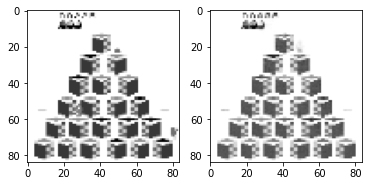

In [751]:
test_ep = 1
episodes = 5
highest_score = 0
screen = screensize
average = 0
dims = val.shape[-1]
import cv2
for episode in range(test_ep):
    next_game = str(np.random.choice(single_atari,1)[0])
    env = gym.make(next_game+'-v0',full_action_space=True,obs_type="image")
    print("Playing",next_game)
    state = env.reset()
    #print("Assault state",state.shape)
    done = False
    score = 0
    i=0
    while not done:
        action = env.action_space.sample()
        #print("ACTION:",action) #simply an int for Atari
        #print("Action type",type(action))
        n_state, reward, done, info = env.step(action)
        #print("obs shape",n_state.shape)
        if i==178:
            #res = cv2.resize(env.env.ale.getScreenRGB(),(screen,screen))
            res = cv2.resize(env.env.ale.getScreenGrayscale(),(screen,screen))
            res = tf.convert_to_tensor(res,dtype=tf.float32)
            res /= 255
            to_eval = np.reshape(res,(1,screen,screen ,dims))
            encoded_image = new_enc(to_eval)
            #print("ENCODED IMAGE",encoded_image)
            #print("ENCODED IMAGE SHAPE",encoded_image[2].shape)
            decoded_image = new_dec(encoded_image[0])
            print("DECODED IMAGE SHAPE",decoded_image.shape)
            to_comp = np.reshape(decoded_image,(screen,screen,dims))
            to_eval = np.reshape(res,(screen,screen,dims))
            save_image(to_eval,to_comp,i=i)
        score+=reward
        i+=1
    print("Game: {} Score: {} After {} steps".format(episode+1,score,i))
    if score > highest_score:
        highest_score=score
    average += score
    final_avg = average/episodes
    
print("Highest Score:",highest_score,"Average of:",final_avg,"over",episodes,"episodes")
env.close()


In [ ]:
nextimage = np.reshape(val[175],(1,screensize,screensize,val.shape[-1]))
nextimage /= 255
enc_image = new_enc(nextimage)
dec_image = new_dec(enc_image[0])
final_image = np.reshape(dec_image,(screensize,screensize,val.shape[-1]))
plot_image(final_image,save=False)

In [ ]:
save_image(val[175],final_image,i=1985)

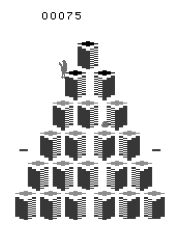

In [686]:
plot_image(env.env.ale.getScreenGrayscale())

In [26]:
MyVae.encoder.save("/Users/antoniomone/Downloads/myEncoder.h5")
MyVae.decoder.save("/Users/antoniomone/Downloads/myDecoder.h5")